# Configuração experimental usando três elementos dispersivos após a transmissão de 55km

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from commpy.modulation import QAMModem

# Modulos do OptiCommpy
from pyfiles.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from pyfiles.models import phaseNoise, KramersKronigRx, linFiberCh
from pyfiles.tx import simpleWDMTx
from pyfiles.core import parameters
from pyfiles.equalization import edc, mimoAdaptEqualizer
from pyfiles.carrierRecovery import cpr
from pyfiles.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from pyfiles.plot import pconst

import scipy.constants as const
# Modulo responsável pelo pre-processamento, criação de datasets, treinamento e criação de modelos. 
#from pyfiles.functions import get_model

### Simulação de uma transmissão de sinal óptico

In [2]:
## Parâmetros do Transmissor:

paramTx = parameters()
paramTx.M = 16                 # ordem do formato de modulação
paramTx.Rs = 32e9              # taxa de símbolo [baud]
paramTx.SpS = 4                # amostras por símbolo
paramTx.Nbits = 400000         # número total de bits por polarização
paramTx.pulse = "rrc"          # filtro de modelagem de pulso
paramTx.Ntaps = 1024           # número de coeficientes de filtro de modelagem de pulso
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # potência do sinal óptico [dBm]
paramTx.Nch = 1                # número de canais WDM
paramTx.Fc = 193.1e12          # frequência central do espectro óptico
paramTx.freqSpac = 37.5e9      # espaçamento da grade WDM

## Parâmetros do canal óptico:

Ltotal = 55      # distância total do link [km]
alpha = 0        # parâmetro de perda da fibra [dB/km]
D = 16           # parâmetro de disperção [ps/nm/km]
Fc = paramTx.Fc  # frequência óptica central do espectro WDM [Hz]

## Parâmetros do receptor:

# local oscillator (LO) - Alterar a frequência do sinal.
FO = paramTx.Rs/2   # deslocamento de frequência
lw = 0*200e3        # espessura da linha
ϕ_lo = 0            # fase inicial em rad
Plo_dBm = 12        # potência em dBm

# Taxa de amostragem ADC
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 2

## Parâmetros gerais de simulação:

chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

### Script de simulação do núcleo

In [3]:
def LO_generate(sigCh, Plo, FO, Ts):
    """
    Gera o campo LO sobre o sinal recebido

    param sigCh: Sinal óptico
    param Plo: Potência em w
    param FO: Deslocamento de frequência
    param Ts: intervalo de sinalização 

    return sfm: símbolos a serem observados.
    return sigRx: sinal recebido.
    """
    π = np.pi
    
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)
    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    
    # Adiciona o campo LO para o sinal recebido
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    return sfm, sigRx


In [4]:
# Gera o sinal óptico
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# Simula a propagação de sinal linear na fibra
sigCh_0 = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)
# Adiciona multiplas disperções
sigCh_1 = linFiberCh(sigTx, 25, alpha, D, Fc, Fs)
sigCh_2 = linFiberCh(sigTx, 35, alpha, D, Fc, Fs)
sigCh_3 = linFiberCh(sigTx, 55, alpha, D, Fc, Fs)

# plota o espectro óptico antes e depois da transmissão

# Antes
""" plt.figure(figsize=(12, 9))
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# Depois
plt.psd(
    sigCh_0,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend()
plt.title("optical spectrum")
 """

# Números de elementos dispersivos
N = 4
# Detecção e demodulação do receptor
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]
Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# Gera o campo LO para todas as disperções
sfm_0, sigRx_0 = LO_generate(sigCh_0, Plo, FO, Ts)
sfm_1, sigRx_1 = LO_generate(sigCh_1, Plo, FO, Ts)
sfm_2, sigRx_2 = LO_generate(sigCh_2, Plo, FO, Ts)
sfm_3, sigRx_3 = LO_generate(sigCh_3, Plo, FO, Ts)

# plota o espectro após adicionar LO
""" plt.psd(
    sigRx_0,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend()
plt.title("optical WDM spectrum");
 """;

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz


### Simulação do receptor óptico de detecção direta ideal

In [5]:
def Intensity_Values_and_Phase(sfm):
    """
    Retorna valores de intensidade e fase do sinal

    para sfm:
    return Amp, sigPhase: Amplitude e Fase do sinal recebido.
    """
    Amp = np.abs(sfm)
    Amp = resample(Amp, paramADC)

    sigPhase = np.angle(sfm)

    return Amp, sigPhase

In [18]:
## Realiza a reamostragem para taxa de amostragem ADC ##

for index in range(0, N):
    # Reamostragem para SigCh_index
    sigCh = globals().get('sigCh_%d' % index)
    sigCh = resample(sigCh, paramADC)
    # Reamostragem para sfm_index
    sfm = globals().get('sfm_%d' % index)
    sfm = resample(sfm, paramADC)

""" sigCh_0 = resample(sigCh_0, paramADC)
sigCh_1 = resample(sigCh_1, paramADC)
sigCh_2 = resample(sigCh_2, paramADC)
sigCh_3 = resample(sigCh_3, paramADC)

sfm_0 = resample(sfm_0, paramADC)
sfm_1 = resample(sfm_1, paramADC)
sfm_2 = resample(sfm_2, paramADC)
sfm_3 = resample(sfm_3, paramADC)
 """
newFs = paramADC.SpS_out*paramTx.Rs

## Simulação de uma detecção direta ideal ##

#Amp_0, sigPhase_0 = Intensity_Values_and_Phase(sfm_0) # Primeiro sinal óptico 
#Amp_1, sigPhase_1 = Intensity_Values_and_Phase(sfm_1) # Elemento dispersivo em 25km
#Amp_2, sigPhase_2 = Intensity_Values_and_Phase(sfm_2) # Elemento dispersivo em 35km
#Amp_3, sigPhase_3 = Intensity_Values_and_Phase(sfm_3) # Elemento dispersivo em 55km

### Estágio de recuperação de fase

In [9]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

Epoch 1/100
4375/4375 [==============================] - 6s 1ms/step - loss: 0.0024 - val_loss: 4.0612e-04
Epoch 2/100
4375/4375 [==============================] - 5s 1ms/step - loss: 5.8329e-04 - val_loss: 4.1657e-04
Epoch 3/100
4375/4375 [==============================] - 5s 1ms/step - loss: 5.1993e-04 - val_loss: 3.3012e-04
Epoch 4/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.7450e-04 - val_loss: 3.3256e-04
Epoch 5/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.6614e-04 - val_loss: 3.0003e-04
Epoch 6/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.5199e-04 - val_loss: 3.0267e-04
Epoch 7/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.3937e-04 - val_loss: 2.6750e-04
Epoch 8/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.3363e-04 - val_loss: 2.6283e-04
Epoch 9/100
4375/4375 [==============================] - 5s 1ms/step - loss: 4.4365e-04 - val_loss: 2.7034e-04
Epoch

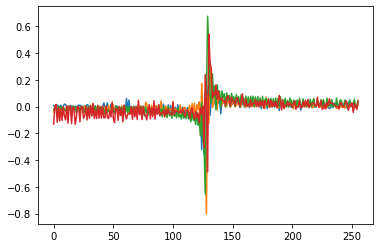

In [40]:
M = 256  # Número de amostras de amplitude para RNA

sfm = np.concatenate((sfm_0, sfm_1, sfm_2, sfm_3))
sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm)  # Amostras de fase (L,)
sigAmp = np.pad(np.abs(sfm), (int(M/2), int(M/2)), 'constant')  # Amostras de Amplitudes (L,)

X_train = np.zeros((len(sigPhase), M))

for index in range(len(sigPhase)):
    X_train[index] = sigAmp[index:M+index]

y_train = sigPhase.copy()

# definindo o modelo da rede neural
stop = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(M,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)

model.summary()

cw1 = model.layers[1].get_weights()
plt.plot(cw1[0])

In [41]:
phiTime_NN = model.predict(X_train)
phiTime_NN = phiTime_NN.reshape(-1,)

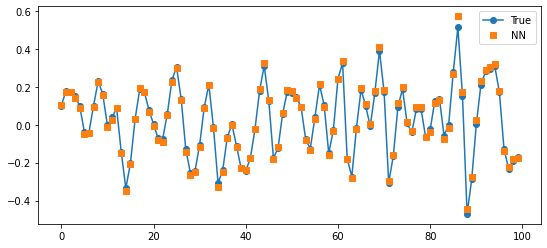

In [42]:
plt.figure(figsize=(9, 4))
plt.plot(np.angle(sfm)[300:400], '-o', label='True')
plt.plot(phiTime_NN[300:400], 's', label='NN')
plt.legend()

In [43]:
M = model.layers[1].get_weights()[0].shape[0]

# Gera sinal óptico
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# Simula a propagação de sinal linear na fibra
sigCh_0 = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)
# Adiciona multiplas disperções
sigCh_1 = linFiberCh(sigTx, 25, alpha, D, Fc, Fs)
sigCh_2 = linFiberCh(sigTx, 35, alpha, D, Fc, Fs)
sigCh_3 = linFiberCh(sigTx, 55, alpha, D, Fc, Fs)

# Detecção e demodulação do receptor
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]
Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# Gera o campo LO para todas as disperções
sfm_0, sigRx_0 = LO_generate(sigCh_0, Plo, FO, Ts)
sfm_1, sigRx_1 = LO_generate(sigCh_1, Plo, FO, Ts)
sfm_2, sigRx_2 = LO_generate(sigCh_2, Plo, FO, Ts)
sfm_3, sigRx_3 = LO_generate(sigCh_3, Plo, FO, Ts)

## Realiza a reamostragem para taxa de amostragem ADC ##

for index in range(0, N):
    # Reamostragem para SigCh_index
    sigCh = globals().get('sigCh_%d' % index)
    sigCh = resample(sigCh, paramADC)
    # Reamostragem para sfm_index
    sfm = globals().get('sfm_%d' % index)
    sfm = resample(sfm, paramADC)

newFs = paramADC.SpS_out*paramTx.Rs

## Simulação da detecção direta ideal

#Amp_0, sigPhase_0 = Intensity_Values_and_Phase(sfm_0) # Primeiro sinal óptico
#Amp_1, sigPhase_1 = Intensity_Values_and_Phase(sfm_1) # Elemento dispersivo em 25km
#Amp_2, sigPhase_2 = Intensity_Values_and_Phase(sfm_2) # Elemento dispersivo em 35km
#Amp_3, sigPhase_3 = Intensity_Values_and_Phase(sfm_3) # Elemento dispersivo em 55km

for index in range(0, N):
    sfm = globals().get('sfm_%d' % index)
    sfm = sfm/np.sqrt(signal_power(sfm))

# Valores de fase esperados para os quatro sinais
sigPhase_0 = np.angle(sfm_0)
sigPhase_1 = np.angle(sfm_1)
sigPhase_2 = np.angle(sfm_2)
sigPhase_3 = np.angle(sfm_3)

# Valores de Amplitudes por DD
sigAmp_0 = np.pad(np.abs(sfm_0), (int(M/2), int(M/2)), 'constant')
sigAmp_1 = np.pad(np.abs(sfm_1), (int(M/2), int(M/2)), 'constant')
sigAmp_2 = np.pad(np.abs(sfm_2), (int(M/2), int(M/2)), 'constant')
sigAmp_3 = np.pad(np.abs(sfm_3), (int(M/2), int(M/2)), 'constant')

X_input_0 = np.zeros((len(sigPhase_0), M))

for index in range(len(sigPhase_0)):
    X_input_0[index] = sigAmp_0[index:M+index]

# Reconstrução do primeiro sinal sigCh_0
phiTime_NN_0 = model.predict(X_input_0) 
phiTime_NN_0 = phiTime_NN_0.reshape(-1,)

sigRx_0 = np.abs(sfm_0)*np.exp(1j*phiTime_NN_0)

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
